# Turtlebot 3 Step Response Code

This code snippet records the linear velocity step response of a Turtlebot 3 robot end-to-end using localisation published to ROS tf. This makes the step response measurement applicable to simulated and real robots. The implementation is based on ROS Noetic.

[INFO] [1713686640.089258, 532.716000]: Script setup sucessfully. Waiting for initial transform
[INFO] [1713686640.156058, 532.783000]: Got initial transformation. Sending cmd_vel linear step up
[INFO] [1713686640.157713, 532.784000]: Measuring linear velocity response step up
[INFO] [1713686641.691536, 534.316000]: Got step up. Sending cmd_vel linear step down
[INFO] [1713686641.693639, 534.318000]: Measuring linear velocity response step down


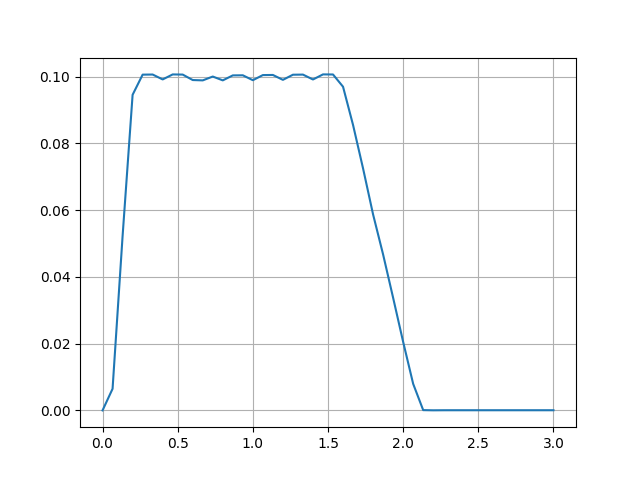

In [9]:
## Measurement using TF would maybe work for real HW using state estimation
%matplotlib ipympl

import rospy
import tf2_ros
from geometry_msgs.msg import Twist

import numpy as np
import matplotlib.pyplot as plt


## Configuration
stepHeight = (0, 0.1)
testTime = 3 #sec
ts = 1/15 #sec
samples = int(testTime*(1/ts)) + 2
timeDisc = [ i*ts for i in range(samples-1) ]
inSignal = [stepHeight[0]] + [ stepHeight[1] for _ in range(samples-1) ]

## Init ROS
rospy.init_node("robot_step_response2")
# TF listener
tfBuffer = tf2_ros.Buffer()
tfListener = tf2_ros.TransformListener(tfBuffer)
rospy.Rate(1.0).sleep()
# cmd_vel publisher
pub = rospy.Publisher("cmd_vel", Twist, queue_size=1)
rospy.Rate(1.0).sleep()

rosRate = rospy.Rate(int(1/ts))

rospy.loginfo("Script setup sucessfully. Waiting for initial transform")

msg = Twist()
msg.linear.x = stepHeight[0]
pub.publish(msg)

transform = None
X = []

while (transform is None) and (not rospy.is_shutdown()):
    try:
        transform = tfBuffer.lookup_transform("odom", "base_footprint", rospy.Time(0), rospy.Duration(1.0))
        X.append(transform.transform.translation.x)
    except (tf2_ros.LookupException, tf2_ros.ConnectivityException, tf2_ros.ExtrapolationException) as e:
        rospy.logerr(e)
        continue

rosRate.sleep()

## Upwards step
rospy.loginfo("Got initial transformation. Sending cmd_vel linear step up")

msg = Twist()
msg.linear.x = stepHeight[1]
pub.publish(msg)

rospy.loginfo("Measuring linear velocity response step up")

for i in range(int(samples/2)):
    try:
        transform = tfBuffer.lookup_transform("odom", "base_footprint", rospy.Time(0), rospy.Duration(1.0))
        X.append(transform.transform.translation.x)
    except (tf2_ros.LookupException, tf2_ros.ConnectivityException, tf2_ros.ExtrapolationException) as e:
        rospy.logerr(e)
        continue
    rosRate.sleep()

## Downward step
rospy.loginfo("Got step up. Sending cmd_vel linear step down")

msg = Twist()
msg.linear.x = stepHeight[0]
pub.publish(msg)

rospy.loginfo("Measuring linear velocity response step down")

for i in range(int(samples/2)):
    try:
        transform = tfBuffer.lookup_transform("odom", "base_footprint", rospy.Time(0), rospy.Duration(1.0))
        X.append(transform.transform.translation.x)
    except (tf2_ros.LookupException, tf2_ros.ConnectivityException, tf2_ros.ExtrapolationException) as e:
        rospy.logerr(e)
        continue
    rosRate.sleep()

# Plot result
dx = np.diff(X)
vel = dx/ts

fig, ax = plt.subplots()

ax.plot(timeDisc, vel)
ax.grid()
plt.show()

## Interpretation of Results

$D > 1$ $\to$ Aperiodic case. This means, that two time constants can be fitted to each of the slopes geometrically. We do that empirically here, by tuning one set of time constants that fits the robot well enough, as behaviour for positive and negative acceleration are different in the step response.

- $T_u$: $0.123$ sec
- $T_a$: $0.153$ sec

Next, we can use an approximated transfer function (this one uses the Trapezoid/Tustin approximation) to plot behaviour of our model over time. The time-discrete case is what is easiest to integrate into microcontrollers and real robots, as there is no differential equation that has to be solved (the transfer element approximation does that for us).

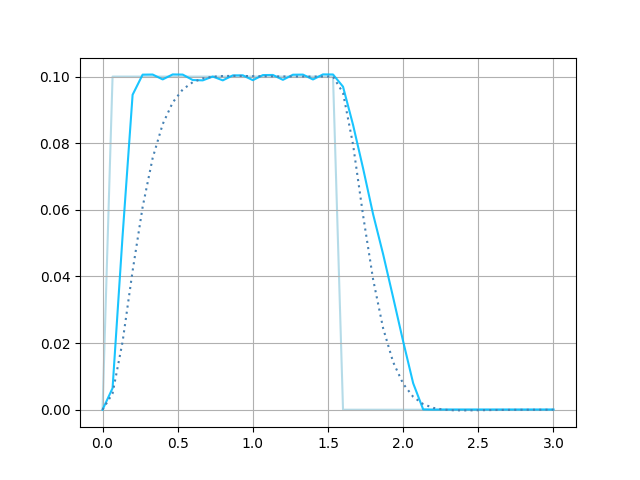

In [22]:
inSignal = [stepHeight[0]] + [ stepHeight[1] for _ in range(int(samples/2)) ] + [ stepHeight[0] for _ in range(int(samples/2)-1) ]

class PT2Block:
    """!@brief Discrete PT2 Block approximated using the Tustin approximation """
    def __init__(self, T=0, D=0, kp=1, ts=0, bufferLength=3) -> None:
        self.k1 = 0
        self.k2 = 0
        self.k3 = 0
        self.k4 = 0
        self.k5 = 0
        self.k6 = 0
        self.e = [0 for i in range(bufferLength)]
        self.y = [0 for i in range(bufferLength)]
        if ts != 0:  self.setConstants(T, D, kp, ts)
    #
    def setConstants(self, T, D, kp, ts):
        """ Updates controller constants """
        self.k1 = 4*T**2 + 4*D*T*ts + ts**2
        self.k2 = 2*ts**2 - 8*T**2
        self.k3 = 4*T**2 - 4*D*T*ts + ts**2
        self.k4 = kp*ts**2
        self.k5 = 2*kp*ts**2
        self.k6 = kp*ts**2
    #
    def update(self, e):
        """
        Performs one discrete controller update 
        
        Receives: Input signal [float]
        Returns: Output signal [float]
        """        
        # Update buffered input and output signals
        self.e = [e]+self.e[:len(self.e)-1]
        self.y = [0]+self.y[:len(self.y)-1]
        # Shorten variable names for better readability
        e = self.e
        y = self.y
        # Calculate output signal and return output
        y[0] = ( e[0]*self.k4 + e[1]*self.k5 + e[2]*self.k6 - y[1]*self.k2 - y[2]*self.k3 )/self.k1
        return y[0]

PT2 = PT2Block(ts=ts, T=0.12, D=0.9)
simDisc = [ PT2.update(s) for s in inSignal ]

## Plot comparison between measured and approximated behaviour
fig, ax = plt.subplots()

labels = [
    "Modelled Transfer Element Output",
    "Measured Transfer Element Output",
    "Input Step Signal"
]

linestyles = ["--", "-", "-"]
dashShape = (1, 2) # len 1, interval 5

colours = [
    "steelblue",
    "deepskyblue",
    "lightblue"
]

alphas = [1.0, 0.9, 0.9]
zorder = [3, 2, 1]


ax.plot(timeDisc, simDisc, label=labels[0], linestyle=linestyles[0], color=colours[0], alpha=alphas[0], zorder=zorder[0], dashes=dashShape)

# Plot discrete
ax.plot(timeDisc, vel, label=labels[1], linestyle=linestyles[1], color=colours[1], alpha=alphas[1], zorder=zorder[1])
ax.plot(timeDisc, inSignal, label=labels[2], linestyle=linestyles[2], color=colours[2], alpha=alphas[2], zorder=zorder[2])

ax.grid()
plt.show()

Alternatively, we can model behaviour with scipy's `signal` library, which solves the transfer function automatically. In this example, we set different constants for the two slopes to be as accurate as possible.

In [21]:
## Tu, Tg rising
tu = 0.125
ta = 0.269
print(tu/tg)

## Tu, Tg falling
tu = 0.068
tg = 0.375
print(tu/tg)

0.3333333333333333
0.18133333333333335


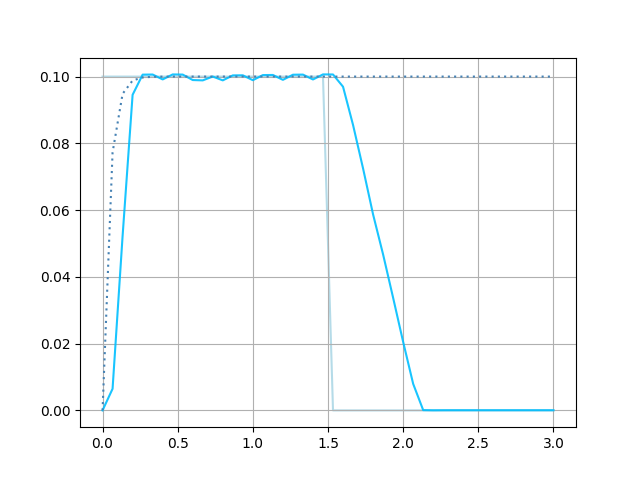

In [10]:
## Modelling using scipy signal library

#stepHeight = (0, 0.1)
#testTime = 3 #sec
#ts = 1/15 #sec
#samples = int(testTime*(1/ts))
#timeDisc = [ i*ts for i in range(samples-1) ]
inSignal = [ stepHeight[1] for _ in range(int(samples/2)) ] + [ stepHeight[0] for _ in range(int(samples/2)) ]

from scipy import signal

tu = 0.125
ta = 0.269

tu = 0.0
ta = 0.045

t = 0.045
delay = 0.14
delay = 0

timeCont, resultCont = signal.step(
    #signal.lti([0, stepHeight[1]], [t, 1]),
    signal.lti([0, 0, stepHeight[1]], [tu*ta, tu+ta, 1]), # https://de.wikipedia.org/wiki/PT2-Glied
    T=timeDisc
)

## Plot comparison between measured and approximated behaviour
fig, ax = plt.subplots()

labels = [
    "Modelled Transfer Element Output",
    "Measured Transfer Element Output",
    "Input Step Signal"
]

linestyles = ["--", "-", "-"]
dashShape = (1, 2) # len 1, interval 5

colours = [
    "steelblue",
    "deepskyblue",
    "lightblue"
]

alphas = [1.0, 0.9, 0.9]
zorder = [3, 2, 1]


ax.plot(timeCont+delay, resultCont, label=labels[0], linestyle=linestyles[0], color=colours[0], alpha=alphas[0], zorder=zorder[0], dashes=dashShape)

# Plot discrete
ax.plot(timeDisc, vel, label=labels[1], linestyle=linestyles[1], color=colours[1], alpha=alphas[1], zorder=zorder[1])
ax.plot(timeDisc, inSignal, label=labels[2], linestyle=linestyles[2], color=colours[2], alpha=alphas[2], zorder=zorder[2])

ax.grid()
plt.show()